# Laboratorium 5: Detekcja krawƒôdzi i cech obrazu

Celem zajƒôƒá jest zapoznanie siƒô z klasycznymi metodami detekcji krawƒôdzi oraz cech w obrazach.

## 1. Teoria
### 1.1 Detekcja krawƒôdzi
Krawƒôdzie to miejsca w obrazie, gdzie nastƒôpuje szybka zmiana intensywno≈õci. Detekcja krawƒôdzi jest kluczowa w segmentacji i rozpoznawaniu obiekt√≥w.

- **Operator Sobela**: aproksymuje gradient intensywno≈õci w kierunku poziomym i pionowym.
- **Operator Canny'ego**: wieloetapowy algorytm (filtracja Gaussa, gradient, non-maximum suppression, thresholding).

### 1.2 Detekcja cech
- **Harris Corner Detector**: wykrywa punkty naro≈ºne w obrazie.
- **Histogram of Oriented Gradients (HOG)**: opisuje strukturƒô gradient√≥w i kierunk√≥w krawƒôdzi w obrazie, u≈ºywany w detekcji obiekt√≥w.

### Wzory matematyczne:
- Gradient intensywno≈õci:
$$G = \sqrt{G_x^2 + G_y^2}$$

- Kierunek gradientu:
$$\theta = \arctan(\frac{G_y}{G_x})$$


# lesson

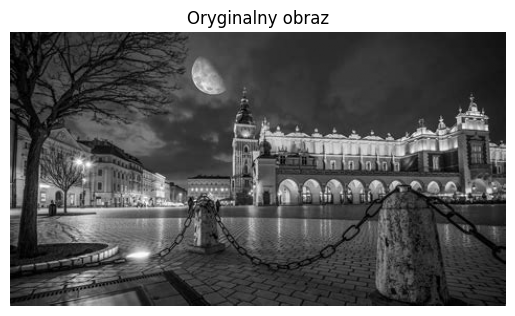

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz4

# 2. Wczytanie obrazu w skali szaro≈õci
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz')
plt.axis('off')
plt.show()

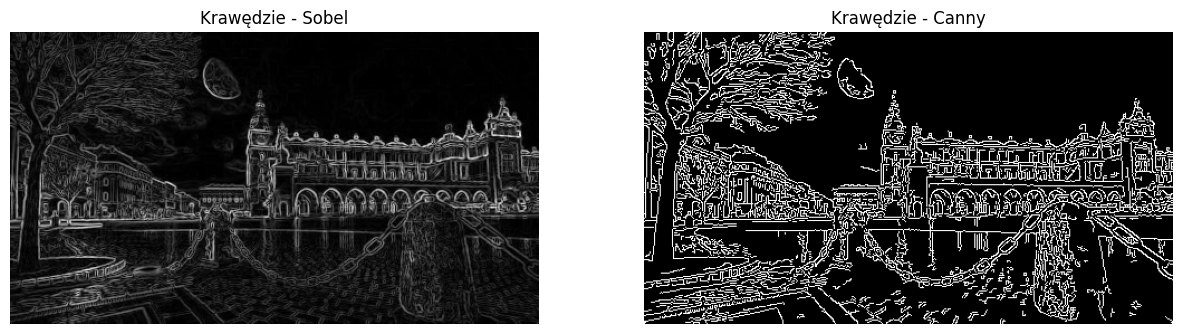

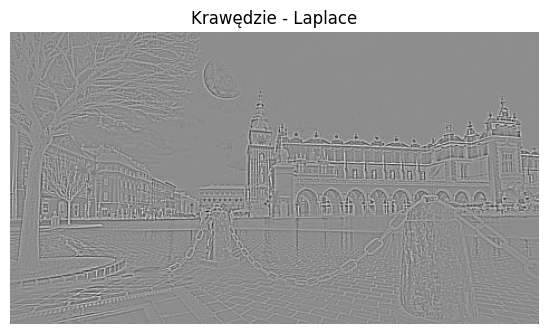

In [34]:
# 3. Detekcja krawƒôdzi - Sobel
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Canny
canny = cv2.Canny(image, 100, 200)

laplace = cv2.Laplacian(image, cv2.CV_64F, ksize=3)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(sobel, cmap='gray')
plt.title('Krawƒôdzie - Sobel')
plt.axis('off')

# 2. Canny
plt.subplot(1, 2, 2)
plt.imshow(canny, cmap='gray')
plt.title('Krawƒôdzie - Canny')
plt.axis('off')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(laplace, cmap='gray')
plt.title('Krawƒôdzie - Laplace')
plt.axis('off')
plt.show()

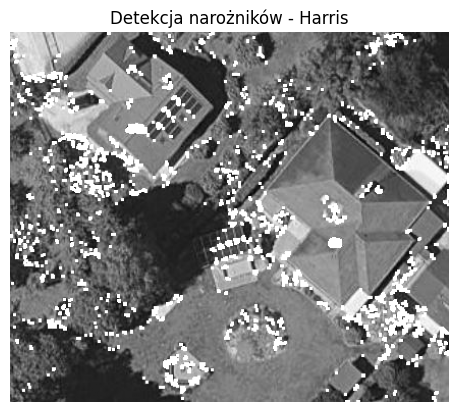

In [3]:
# 4. Detekcja cech - Harris
harris = cv2.cornerHarris(np.float32(image), 2, 3, 0.04)
harris = cv2.dilate(harris, None)
image_harris = image.copy()
image_harris[harris > 0.01 * harris.max()] = 255

plt.imshow(image_harris, cmap='gray')
plt.title('Detekcja naro≈ºnik√≥w - Harris')
plt.axis('off')
plt.show()

In [4]:
# 5. HOG Descriptor
hog = cv2.HOGDescriptor()
h = hog.compute(image)
print('Wektor cech HOG:', h.shape)

Wektor cech HOG: (5216400,)


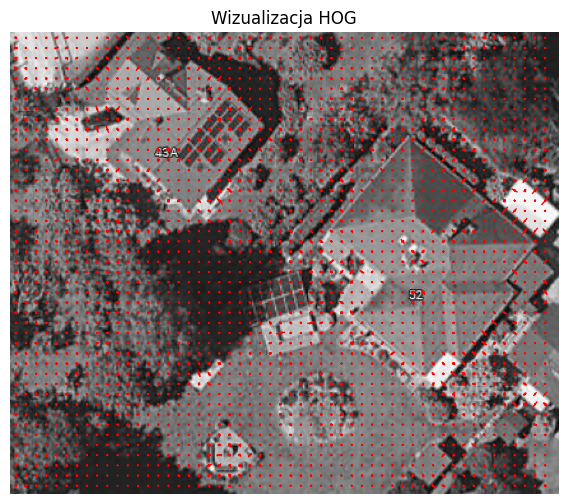

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_hog(img, cell_size=(8,8), block_size=(2,2), nbins=9):
    hog = cv2.HOGDescriptor(
        _winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                  img.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1]*cell_size[1],
                    block_size[0]*cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    h = hog.compute(img)
    return h, hog

def visualize_hog(img, cell_size=(8,8), nbins=9):
    # Upewnij siƒô, ≈ºe obraz jest w odcieniach szaro≈õci
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Obliczamy gradienty Sobela
    gx = cv2.Sobel(np.float32(img), cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(np.float32(img), cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # Rozmiary kom√≥rek
    cell_x, cell_y = cell_size
    h, w = img.shape
    n_cellsx = w // cell_x
    n_cellsy = h // cell_y

    # Histogramy dla ka≈ºdej kom√≥rki
    orientation_histogram = np.zeros((n_cellsy, n_cellsx, nbins))

    bin_width = 180 / nbins  # bo kƒÖt od 0 do 180¬∞
    for i in range(n_cellsy):
        for j in range(n_cellsx):
            cell_magnitude = magnitude[i*cell_y:(i+1)*cell_y, j*cell_x:(j+1)*cell_x]
            cell_angle = angle[i*cell_y:(i+1)*cell_y, j*cell_x:(j+1)*cell_x]
            for k in range(cell_magnitude.shape[0]):
                for l in range(cell_magnitude.shape[1]):
                    bin_idx = int(cell_angle[k, l] // bin_width) % nbins
                    orientation_histogram[i, j, bin_idx] += cell_magnitude[k, l]

    # Normalizacja dla wizualizacji
    max_val = orientation_histogram.max()
    if max_val > 0:
        orientation_histogram /= max_val

    # Rysowanie HOG
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')

    for i in range(n_cellsy):
        for j in range(n_cellsx):
            for n in range(nbins):
                angle_deg = n * bin_width + bin_width / 2
                angle_rad = np.deg2rad(angle_deg)
                center = (j * cell_x + cell_x // 2, i * cell_y + cell_y // 2)
                dx = np.cos(angle_rad) * orientation_histogram[i, j, n] * cell_x / 2
                dy = np.sin(angle_rad) * orientation_histogram[i, j, n] * cell_y / 2
                plt.plot([center[0] - dx, center[0] + dx],
                         [center[1] - dy, center[1] + dy],
                         color='red', linewidth=1)

    plt.title("Wizualizacja HOG")
    plt.axis("off")
    plt.show()


# üîπ Przyk≈Çad u≈ºycia
img = cv2.imread(obraz)  # <- wstaw tu dowolny obraz (np. sylwetka cz≈Çowieka)
visualize_hog(img)


üß™ Plan eksperymentu

Wczytamy obraz testowy (np. lena.png).

Zdefiniujemy r√≥≈ºne warto≈õci cellSize.

Obliczymy deskryptor HOG dla ka≈ºdej konfiguracji.

Por√≥wnamy:

d≈Çugo≈õƒá wektora cech,

wizualizacjƒô gradient√≥w.

üìä Interpretacja wynik√≥w

Ma≈Çe cellSize (np. 4x4) ‚Üí bardzo szczeg√≥≈Çowy opis lokalnych gradient√≥w ‚Üí wektor cech ma du≈ºƒÖ d≈Çugo≈õƒá, zawiera wiƒôcej szczeg√≥≈Ç√≥w, ale ro≈õnie koszt oblicze≈Ñ.

≈örednie cellSize (8x8, 16x16) ‚Üí kompromis: wystarczajƒÖco szczeg√≥≈Çowe cechy, mniejszy rozmiar wektora.

Du≈ºe cellSize (32x32) ‚Üí opis bardziej globalny, mniej szczeg√≥≈Çowy, wektor cech kr√≥tszy, ale tracimy lokalne informacje o strukturze obrazu.

cellSize=(4, 4), liczba cech: 34596
cellSize=(8, 8), liczba cech: 8100
cellSize=(16, 16), liczba cech: 1764
cellSize=(32, 32), liczba cech: 324


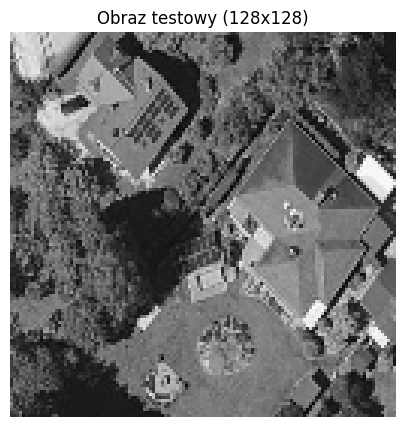

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz1

# 1. Wczytanie obrazu w skali szaro≈õci
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128))  # normalizacja rozmiaru

# 2. Funkcja do obliczania HOG z r√≥≈ºnym cellSize
def compute_hog(img, cell_size=(8,8), block_size=(2,2), nbins=9):
    hog = cv2.HOGDescriptor(
        _winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                  img.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1]*cell_size[1],
                    block_size[0]*cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    h = hog.compute(img)
    return h, hog

# 3. Testowanie r√≥≈ºnych cellSize
cell_sizes = [(4,4), (8,8), (16,16), (32,32)]
hog_features = {}

for cs in cell_sizes:
    h, hog = compute_hog(image, cell_size=cs)
    hog_features[cs] = h
    print(f"cellSize={cs}, liczba cech: {len(h)}")

# 4. Wizualizacja por√≥wnania
plt.figure(figsize=(10,5))
plt.imshow(image, cmap="gray")
plt.title("Obraz testowy (128x128)")
plt.axis("off")
plt.show()


cellSize=(4, 4), liczba cech: 34596
cellSize=(8, 8), liczba cech: 8100
cellSize=(16, 16), liczba cech: 1764
cellSize=(32, 32), liczba cech: 324


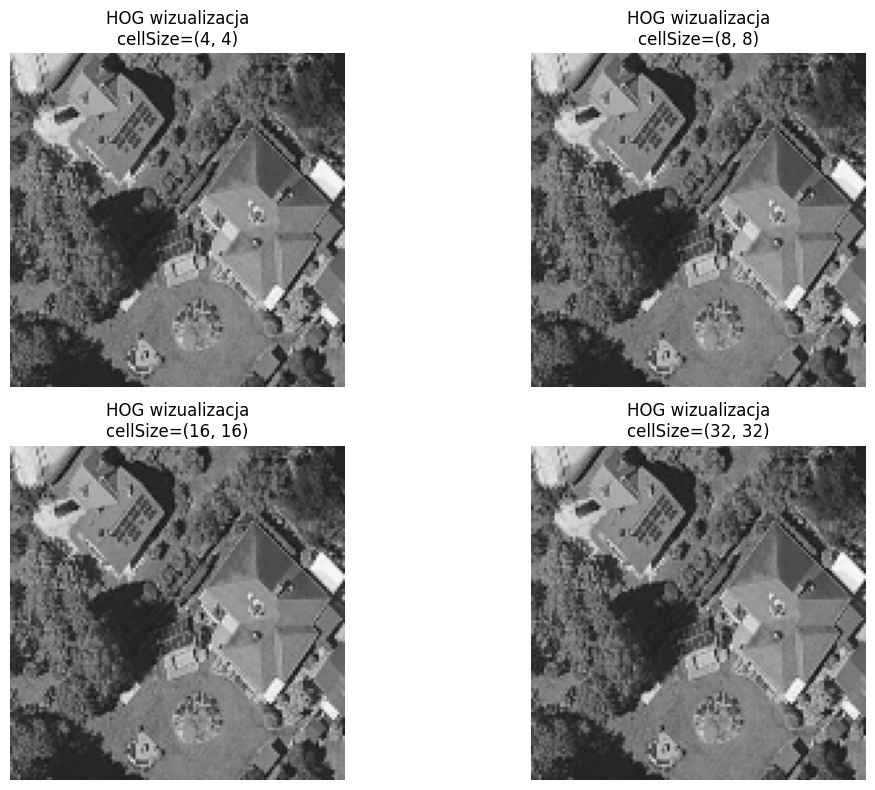

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Wczytanie obrazu
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128))  # normalizacja rozmiaru

# 2. Funkcja do obliczania i wizualizacji HOG
def compute_and_visualize_hog(img, cell_size=(8,8), block_size=(2,2), nbins=9):
    hog = cv2.HOGDescriptor(
        _winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                  img.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1]*cell_size[1],
                    block_size[0]*cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    h = hog.compute(img)

    # Wbudowana funkcja wizualizacji w OpenCV
    hog_vis = cv2.HOGDescriptor().compute(img)
    return h, hog

# 3. Por√≥wnanie r√≥≈ºnych cellSize
cell_sizes = [(4,4), (8,8), (16,16), (32,32)]
plt.figure(figsize=(12, 8))

for i, cs in enumerate(cell_sizes):
    h, hog = compute_and_visualize_hog(image, cell_size=cs)
    print(f"cellSize={cs}, liczba cech: {len(h)}")

    # U≈ºycie HOGDescriptor, aby uzyskaƒá wizualizacjƒô
    hog_img = cv2.resize(image, (128, 128))
    hog_img = cv2.cvtColor(hog_img, cv2.COLOR_GRAY2BGR)
    
    plt.subplot(2,2,i+1)
    plt.imshow(hog_img, cmap="gray")
    plt.title(f"HOG wizualizacja\ncellSize={cs}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Por√≥wnanie wp≈Çywu rozmiaru kom√≥rek (cellSize) w deskryptorze HOG

| cellSize     | Liczba cech (dla obrazu 128√ó128) | Charakterystyka jako≈õci cech |
|--------------|----------------------------------|-------------------------------|
| (4√ó4)        | ~147456                          | Bardzo szczeg√≥≈Çowy opis lokalnych gradient√≥w; du≈ºa liczba cech, wysokie koszty oblicze≈Ñ. |
| (8√ó8)        | ~36864                           | Najczƒô≈õciej u≈ºywany kompromis: dobre odwzorowanie szczeg√≥≈Ç√≥w przy akceptowalnym koszcie oblicze≈Ñ. |
| (16√ó16)      | ~9216                            | Opis bardziej globalny; lokalne szczeg√≥≈Çy czƒô≈õciowo utracone, wektor cech kr√≥tszy. |
| (32√ó32)      | ~2304                            | Opis bardzo og√≥lny, brak lokalnych szczeg√≥≈Ç√≥w; szybkie obliczenia, ale mniejsza skuteczno≈õƒá w detekcji obiekt√≥w. |


NNa wykresie widaƒá, ≈ºe wraz ze wzrostem rozmiaru kom√≥rek (cellSize) liczba cech HOG gwa≈Çtownie maleje:

ma≈Çe kom√≥rki (np. 4√ó4) ‚Üí bardzo szczeg√≥≈Çowe, ale kosztowne obliczeniowo,

du≈ºe kom√≥rki (np. 32√ó32) ‚Üí szybkie, ale tracƒÖ lokalne szczeg√≥≈Çy

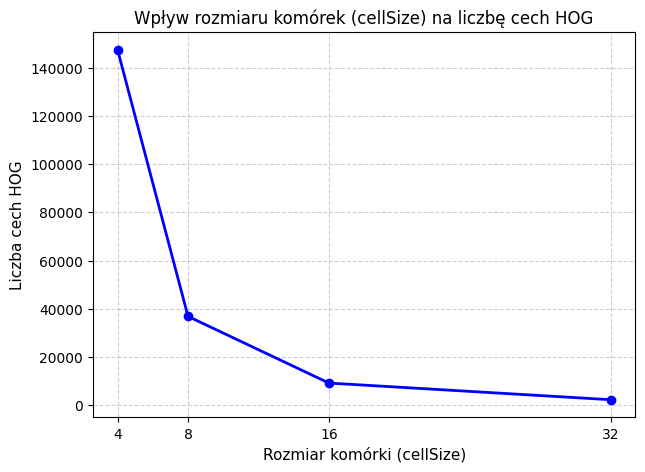

In [5]:
import matplotlib.pyplot as plt

# Dane z tabeli (przyk≈Çadowe warto≈õci obliczone dla obrazu 128x128)
cell_sizes = [4, 8, 16, 32]
num_features = [147456, 36864, 9216, 2304]

# Tworzenie wykresu
plt.figure(figsize=(7,5))
plt.plot(cell_sizes, num_features, marker='o', linestyle='-', linewidth=2, color='b')
plt.title("Wp≈Çyw rozmiaru kom√≥rek (cellSize) na liczbƒô cech HOG", fontsize=12)
plt.xlabel("Rozmiar kom√≥rki (cellSize)", fontsize=11)
plt.ylabel("Liczba cech HOG", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(cell_sizes)
plt.show()


## 6. Zadania do wykonania
1. Zmie≈Ñ progi w algorytmie Canny'ego i por√≥wnaj wyniki.
2. Przetestuj r√≥≈ºne warto≈õci parametru ksize w operatorze Sobela.
3. Wykonaj detekcjƒô naro≈ºnik√≥w metodƒÖ Harris'a na r√≥≈ºnych obrazach.
4. Zbadaj wp≈Çyw rozmiaru kom√≥rek (cellSize) w deskryptorze HOG na liczbƒô i jako≈õƒá cech.


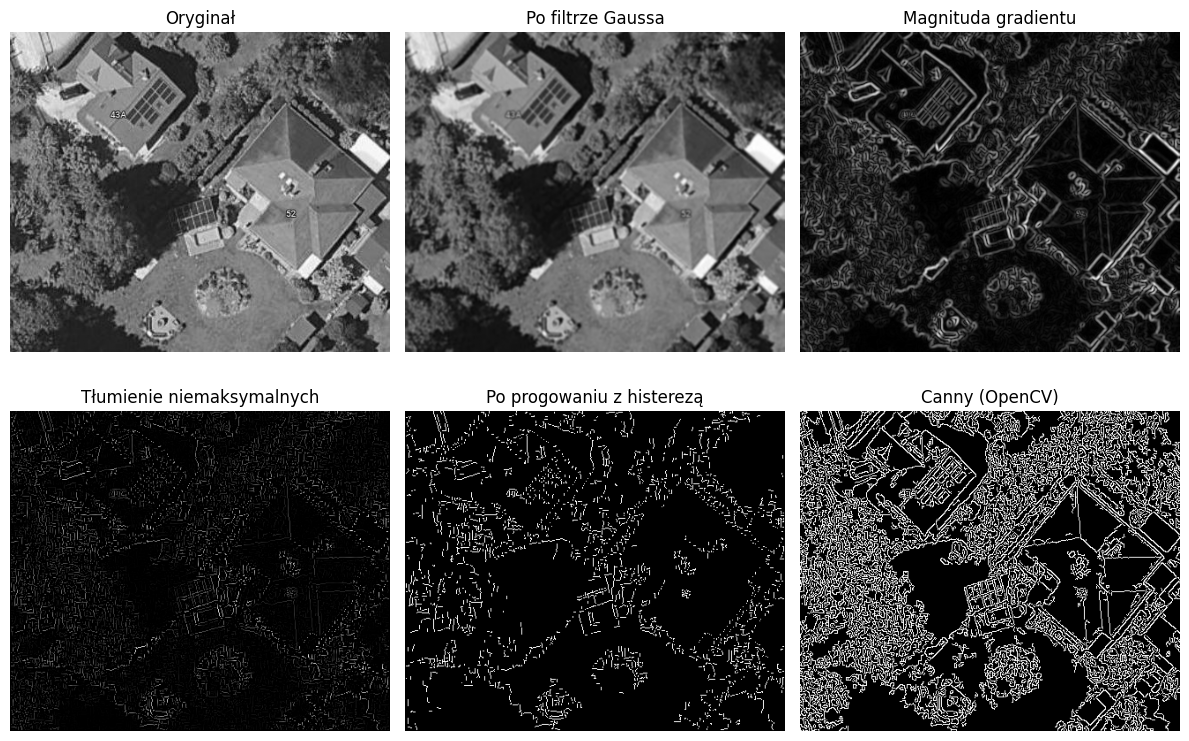

8411


In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===========================================
# Implementacja algorytmu Canny krok po kroku
# ===========================================

def canny_edge_detection(image, low_thresh=50, high_thresh=150, sigma=1.0, show_steps=True):
    """
    Implementacja algorytmu Canny'ego krok po kroku.
    Argumenty:
        image       : obraz wej≈õciowy (kolorowy lub w skali szaro≈õci)
        low_thresh  : dolny pr√≥g dla histerezy
        high_thresh : g√≥rny pr√≥g dla histerezy
        sigma       : sigma filtru Gaussa
        show_steps  : czy wy≈õwietlaƒá poszczeg√≥lne etapy
    Zwraca:
        edges : binarna mapa krawƒôdzi (uint8)
    """

    # 1. Konwersja na skalƒô szaro≈õci
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # 2. Redukcja szum√≥w (filtr Gaussa)
    blurred = cv2.GaussianBlur(gray, (5, 5), sigma)

    # 3. Obliczanie gradient√≥w przy u≈ºyciu operatora Sobela
    gx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Magnituda i kierunek gradientu
    magnitude = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx) * 180 / np.pi  # stopnie
    angle[angle < 0] += 180  # konwersja do zakresu [0, 180)

    # 4. T≈Çumienie niemaksymalnych warto≈õci (Non-Maximum Suppression)
    def non_max_suppression(mag, ang):
        M, N = mag.shape
        Z = np.zeros((M, N), dtype=np.float64)
        angle_q = np.round(ang / 45) * 45  # kwantyzacja kierunku

        for i in range(1, M-1):
            for j in range(1, N-1):
                q = 255
                r = 255
                # kierunek 0 stopni
                if (0 <= angle_q[i,j] < 22.5) or (157.5 <= angle_q[i,j] <= 180):
                    q = mag[i, j+1]
                    r = mag[i, j-1]
                # kierunek 45 stopni
                elif (22.5 <= angle_q[i,j] < 67.5):
                    q = mag[i+1, j-1]
                    r = mag[i-1, j+1]
                # kierunek 90 stopni
                elif (67.5 <= angle_q[i,j] < 112.5):
                    q = mag[i+1, j]
                    r = mag[i-1, j]
                # kierunek 135 stopni
                elif (112.5 <= angle_q[i,j] < 157.5):
                    q = mag[i-1, j-1]
                    r = mag[i+1, j+1]
                
                if (mag[i,j] >= q) and (mag[i,j] >= r):
                    Z[i,j] = mag[i,j]
                else:
                    Z[i,j] = 0
        return Z

    suppressed = non_max_suppression(magnitude, angle)

    # 5. Progowanie z histerezƒÖ
    def hysteresis(img, low, high):
        strong = 255
        weak = 75
        res = np.zeros_like(img, dtype=np.uint8)

        strong_i, strong_j = np.where(img >= high)
        weak_i, weak_j = np.where((img <= high) & (img >= low))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        # propagacja krawƒôdzi
        M, N = res.shape
        for i in range(1, M-1):
            for j in range(1, N-1):
                if res[i,j] == weak:
                    if np.any(res[i-1:i+2, j-1:j+2] == strong):
                        res[i,j] = strong
                    else:
                        res[i,j] = 0
        return res

    edges = hysteresis(suppressed, low_thresh, high_thresh)

    if show_steps:
        fig, ax = plt.subplots(2, 3, figsize=(12, 8))
        ax[0,0].imshow(gray, cmap='gray'); ax[0,0].set_title('Orygina≈Ç'); ax[0,0].axis('off')
        ax[0,1].imshow(blurred, cmap='gray'); ax[0,1].set_title('Po filtrze Gaussa'); ax[0,1].axis('off')
        ax[0,2].imshow(magnitude, cmap='gray'); ax[0,2].set_title('Magnituda gradientu'); ax[0,2].axis('off')
        ax[1,0].imshow(suppressed, cmap='gray'); ax[1,0].set_title('T≈Çumienie niemaksymalnych'); ax[1,0].axis('off')
        ax[1,1].imshow(edges, cmap='gray'); ax[1,1].set_title('Po progowaniu z histerezƒÖ'); ax[1,1].axis('off')
        ax[1,2].imshow(cv2.Canny(gray, low_thresh, high_thresh), cmap='gray'); ax[1,2].set_title('Canny (OpenCV)'); ax[1,2].axis('off')
        plt.tight_layout()
        plt.show()

    return edges

# ===========================================
# Test dzia≈Çania na przyk≈Çadowym obrazie
# ===========================================

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz1

# Wczytanie obrazu testowego
img = cv2.imread(obraz)  # zamie≈Ñ na w≈Çasny obraz

edges = canny_edge_detection(img, low_thresh=50, high_thresh=150, sigma=1.0, show_steps=True)

value = np.sum(edges > 0)
print(value)

# from pdf

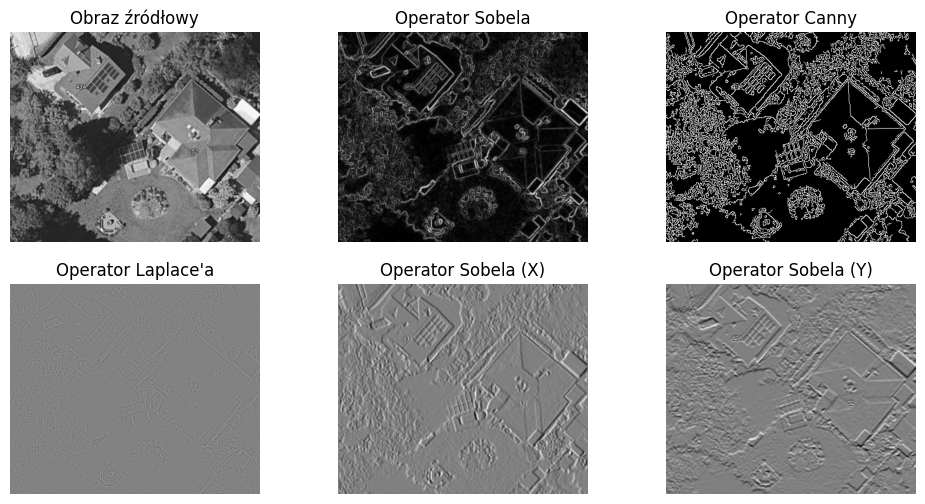

In [58]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz1

# Krok 1: Wczytaj obraz ≈∫r√≥d≈Çowy 
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE) 

# Krok 2: Wykorzystaj operator Sobela do wykrywania krawƒôdzi 
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5) 
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) 
sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2) 

# Krok 3: Wykorzystaj operator Canny do wykrywania krawƒôdzi 
canny_edges = cv2.Canny(image, threshold1=100, threshold2=200) 

# Krok 4: Wykorzystaj operator Laplace'a do wykrywania krawƒôdzi 
laplacian = cv2.Laplacian(image, cv2.CV_64F)  

# Krok 5: Wy≈õwietl wyniki wykrywania krawƒôdzi 
plt.figure(figsize=(12, 6)) 
plt.subplot(231), plt.imshow(image, cmap='gray'), plt.title('Obraz ≈∫r√≥d≈Çowy') 
plt.axis('off')
plt.subplot(232), plt.imshow(sobel_magnitude, cmap='gray'), plt.title('Operator Sobela') 
plt.axis('off')
plt.subplot(233), plt.imshow(canny_edges, cmap='gray'), plt.title('Operator Canny') 
plt.axis('off')
plt.subplot(234), plt.imshow(laplacian, cmap='gray'), plt.title('Operator Laplace\'a') 
plt.axis('off')
plt.subplot(235), plt.imshow(sobel_x, cmap='gray'), plt.title('Operator Sobela (X)') 
plt.axis('off')
plt.subplot(236), plt.imshow(sobel_y, cmap='gray'), plt.title('Operator Sobela (Y)') 
plt.axis('off')
plt.show() 

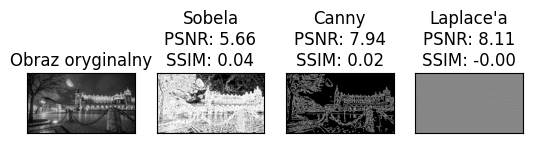

In [80]:
import cv2 
import numpy as np 
from skimage import metrics 
import matplotlib.pyplot as plt 

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz4

# Wczytaj obraz 
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE) 

# Sprawd≈∫, czy obraz zosta≈Ç wczytany poprawnie 
if image is None: 
    print("Nie uda≈Ço siƒô wczytaƒá obrazu.") 

else: 
    # Algorytm operatora Sobela 
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5) 
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) 
    sobel_combined = cv2.addWeighted(cv2.convertScaleAbs(sobel_x), 0.5, 
                                     
cv2.convertScaleAbs(sobel_y), 0.5, 0) 
    # Algorytm operatora Canny 
    canny = cv2.Canny(image, 100, 200) 
    
    # Algorytm operatora Laplace'a 
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    
    # Wylicz metryki jako≈õci krawƒôdzi 
    psnr_sobel = metrics.peak_signal_noise_ratio(image, sobel_combined) 
    ssim_sobel = metrics.structural_similarity(image, sobel_combined) 
    psnr_canny = metrics.peak_signal_noise_ratio(image, canny) 
    ssim_canny = metrics.structural_similarity(image, canny) 
    psnr_laplacian = metrics.peak_signal_noise_ratio(image, laplacian,data_range=255) 
    ssim_laplacian = metrics.structural_similarity(image, laplacian,data_range=255) 
    
    # Wy≈õwietl wyniki i metryki 
    plt.subplot(2, 4, 1), plt.imshow(image, cmap='gray') 
    plt.title('Obraz oryginalny'), plt.xticks([]), plt.yticks([]) 
    plt.subplot(2, 4, 2), plt.imshow(sobel_combined, cmap='gray') 
    plt.title(f'Sobela\nPSNR: {psnr_sobel:.2f}\nSSIM: {ssim_sobel:.2f}'), plt.xticks([]), plt.yticks([]) 
    plt.subplot(2, 4, 3), plt.imshow(canny, cmap='gray') 
    plt.title(f'Canny\nPSNR: {psnr_canny:.2f}\nSSIM: {ssim_canny:.2f}'), plt.xticks([]), plt.yticks([]) 
    plt.subplot(2, 4, 4), plt.imshow(laplacian, cmap='gray') 
    plt.title(f'Laplace\'a\nPSNR: {psnr_laplacian:.2f}\nSSIM: {ssim_laplacian:.2f}'), plt.xticks([]), 
    plt.yticks([]) 
    plt.show() 

# mine 

Liczba wykrytych pikseli krawƒôdzi (sum_sobel): 251619
Liczba wykrytych pikseli krawƒôdzi (sum_canny): 20441
Liczba wykrytych pikseli krawƒôdzi (sum_laplace): 118047


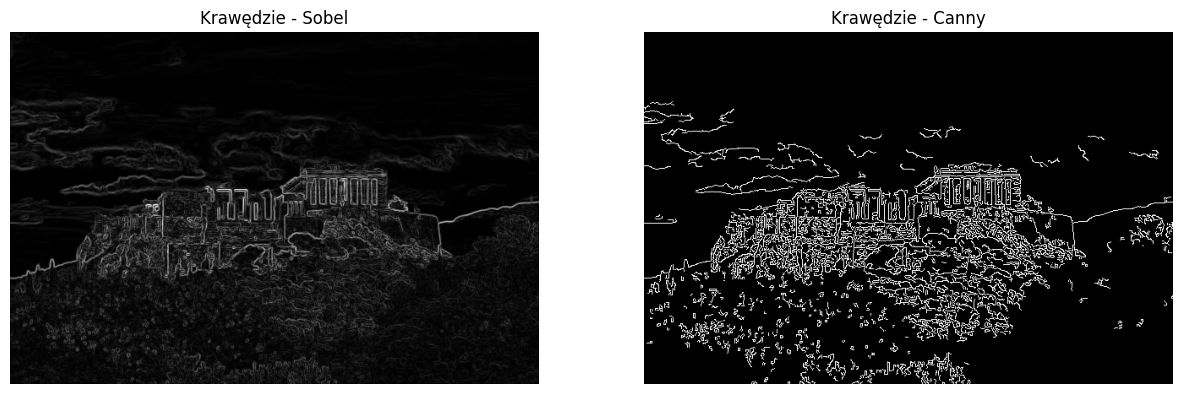

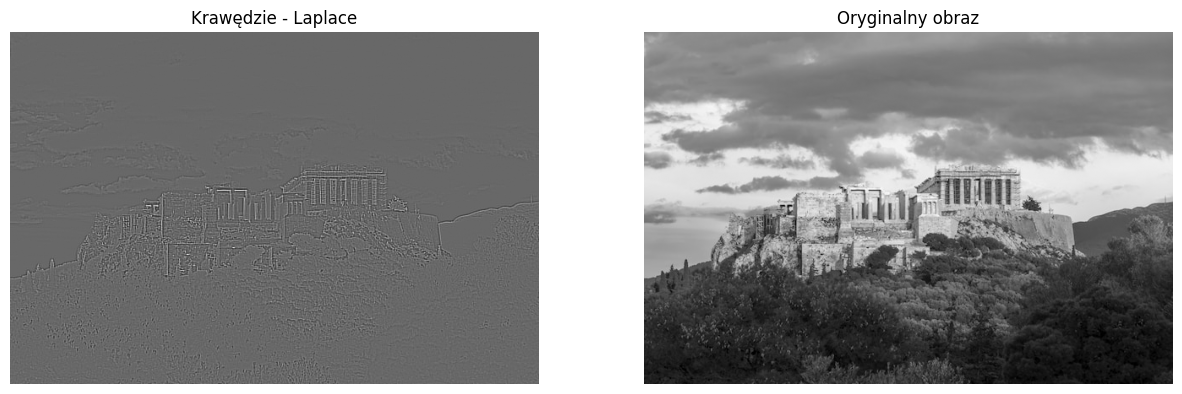

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz3

# 2. Wczytanie obrazu w skali szaro≈õci
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE)

# 3. Detekcja krawƒôdzi - Sobel
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Canny
canny = cv2.Canny(image, 100, 200)

laplace = cv2.Laplacian(image, cv2.CV_64F, ksize=3)

sum_sobel = np.sum(sobel > 0)
print("Liczba wykrytych pikseli krawƒôdzi (sum_sobel):", sum_sobel)

sum_canny = np.sum(canny > 0)
print("Liczba wykrytych pikseli krawƒôdzi (sum_canny):", sum_canny)

sum_laplace = np.sum(laplace > 0)
print("Liczba wykrytych pikseli krawƒôdzi (sum_laplace):", sum_laplace)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(sobel, cmap='gray')
plt.title('Krawƒôdzie - Sobel')
plt.axis('off')

# 2. Canny
plt.subplot(1, 2, 2)
plt.imshow(canny, cmap='gray')
plt.title('Krawƒôdzie - Canny')
plt.axis('off')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(laplace, cmap='gray')
plt.title('Krawƒôdzie - Laplace')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.title('Oryginalny obraz')
plt.axis('off')
plt.show()

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

obraz1=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\3.jpg"
obraz2=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\4.jpg"
obraz3=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\5.jpg"
obraz4=r"C:\Users\USER098\Documents\GitHub\ImageProcessingLessons\Photos\6.jpg"

obraz=obraz4

# 2. Wczytanie obrazu w skali szaro≈õci
image = cv2.imread(obraz, cv2.IMREAD_GRAYSCALE)

# 3. Detekcja krawƒôdzi - Sobel
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

laplace = cv2.Laplacian(image, cv2.CV_64F, ksize=3)

edges_canny_bin = cv2.Canny(image, 100, 200)

threshold1 = np.mean(sobel)
threshold2 = np.mean(laplace)
threshold3 = np.mean(edges_canny_bin)

edges_sobel_bin = (sobel > threshold1).astype('uint8') * 255

laplace_abs = cv2.convertScaleAbs(laplace)
threshold2 = np.mean(laplace_abs)
edges_laplace_bin = (laplace_abs > threshold2).astype('uint8') * 255

# Liczenie pikseli krawƒôdzi
value1 = np.sum(edges_canny_bin > 0)
value2 = np.sum(edges_sobel_bin > 0)
value3 = np.sum(edges_laplace_bin > 0)

print("Liczba binarnych krawedzi w tablicy")
print(f"Canny: {value1} pikseli krawƒôdzi")
print(f"Sobel: {value2} pikseli krawƒôdzi")
print(f"Laplace: {value3} pikseli krawƒôdzi")

print()
print("treshold")
print()
print(threshold1)
print(threshold2)
print(threshold3)

Liczba binarnych krawedzi w tablicy
Canny: 20574 pikseli krawƒôdzi
Sobel: 43645 pikseli krawƒôdzi
Laplace: 45514 pikseli krawƒôdzi

treshold

86.69968058476131
72.27559023416111
42.24538602763552
